# 动量策略： 

Time Series: 时间序列上强者恒强
VS Cross sectional: 行业内部强者恒强


In [1]:
import numpy as np
import pandas as pd
import tushare as ts

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

import warnings; warnings.simplefilter('ignore')       #忽略警告信息；

#### 1. 数据准备 & 回测准备


In [2]:
data = ts.get_k_data('hs300', start = '2010-01-01', end='2020-08-11')[['date','close']]
data.rename(columns={'close': 'price'}, inplace=True)
data.set_index('date', inplace = True)
data.head()

,price
date,
2010-01-04,3535.229
2010-01-05,3564.038
2010-01-06,3541.727
2010-01-07,3471.456
2010-01-08,3480.130


#### 2. 策略开发思路


In [3]:
data['returns'] = np.log(data['price'] / data['price'].shift(1))

In [4]:
data['position'] = np.sign(data['returns'])     
#关键语句,np.sign()很多地方用到；向量化；

#### 3. 计算收益并可视化

In [5]:
data['strategy'] = data['position'].shift(1) * data['returns']  
#计算Momentum策略收益；避免未来函数；

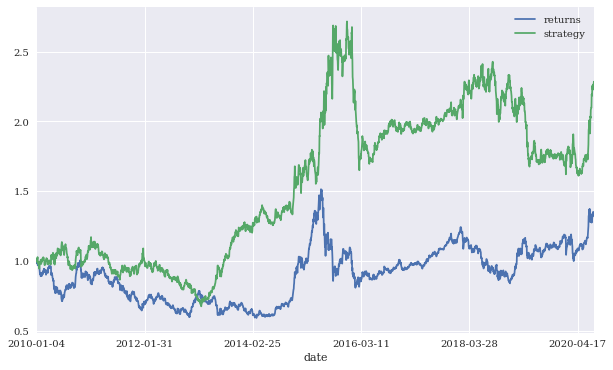

In [6]:
data[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))    
#计算出策略的最终的累计收益；

In [7]:
data[['returns','strategy']].sum()

returns     0.280900
strategy    0.813836
dtype: float64

In [8]:
data[['returns','strategy']].mean() * 252  

returns     0.027469
strategy    0.079614
dtype: float64

In [9]:
data[['returns','strategy']].std() * 252 ** 0.5  

returns     0.233922
strategy    0.233906
dtype: float64

#### 4. 策略优化思路之参数优化和穷举

#针对过多的开仓次数，进行参数优化和穷举

In [10]:
data['position_5'] = np.sign(data['returns'].rolling(5).mean()) 

In [11]:
data['strategy_5'] = data['position_5'].shift(1) * data['returns']

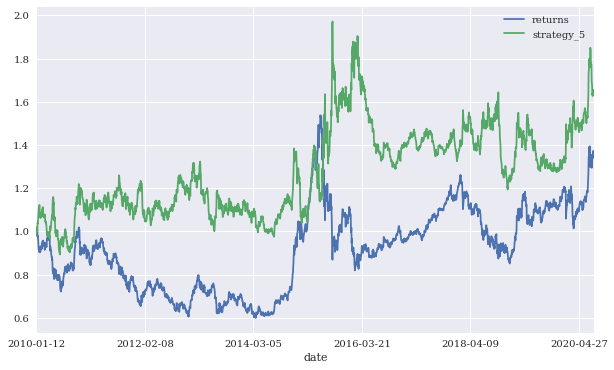

In [12]:
data[['returns', 'strategy_5']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6))

In [13]:
data[['returns','strategy_5']].sum()

returns       0.280900
strategy_5    0.501918
dtype: float64

In [14]:
data[['returns','strategy_5']].mean() * 252  

returns       0.027469
strategy_5    0.049177
dtype: float64

In [15]:
data[['returns','strategy_5']].std() * 252 ** 0.5

returns       0.233922
strategy_5    0.234028
dtype: float64

参数寻优——使用离散Return计算方法

In [16]:
data['return_dis'] = data['price']/data['price'].shift(1) - 1
#data['return_dis'] = data['price'].pct_change()
data['return_dis_cum'] = (1+data['return_dis']).cumprod()

In [17]:
data.tail()

,price,returns,position,strategy,position_5,strategy_5,return_dis,return_dis_cum
date,,,,,,,,
2020-08-05,4777.11,0.000274,1.0,0.000274,1.0,0.000274,0.000274,1.351287
2020-08-06,4762.76,-0.003008,-1.0,-0.003008,1.0,-0.003008,-0.003004,1.347228
2020-08-07,4707.93,-0.011579,-1.0,0.011579,1.0,-0.011579,-0.011512,1.331719
2020-08-10,4724.87,0.003592,1.0,-0.003592,-1.0,0.003592,0.003598,1.336510
2020-08-11,4681.78,-0.009162,-1.0,-0.009162,-1.0,0.009162,-0.009120,1.324322


In [18]:
price_plot = ['return_dis_cum']    #这是用来绘制图形的一个list
type(price_plot)

list

In [19]:
for days in [10, 20, 30, 60]:
        
#     data['position_%d' % days] = np.sign(data['returns'].rolling(days).mean())
    price_plot.append('sty_cumr_%dd' % days)
    data['position_%dd' % days] = np.where(data['returns'].rolling(days).mean()>0,1,-1)
    data['strategy_%dd' % days] = data['position_%dd' % days].shift(1) * data['returns']
    data['sty_cumr_%dd' % days] = (data['strategy_%dd' % days]+1).cumprod()
    
    

In [20]:
price_plot

['return_dis_cum',
 'sty_cumr_10d',
 'sty_cumr_20d',
 'sty_cumr_30d',
 'sty_cumr_60d']

In [21]:
data.head()

,price,returns,position,strategy,position_5,strategy_5,return_dis,return_dis_cum,position_10d,strategy_10d,sty_cumr_10d,position_20d,strategy_20d,sty_cumr_20d,position_30d,strategy_30d,sty_cumr_30d,position_60d,strategy_60d,sty_cumr_60d
date,,,,,,,,,,,,,,,,,,,,
2010-01-04,3535.229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN
2010-01-05,3564.038,0.008116,1.0,NaN,NaN,NaN,0.008149,1.008149,-1,-0.008116,0.991884,-1,-0.008116,0.991884,-1,-0.008116,0.991884,-1,-0.008116,0.991884
2010-01-06,3541.727,-0.006280,-1.0,-0.006280,NaN,NaN,-0.006260,1.001838,-1,0.006280,0.998113,-1,0.006280,0.998113,-1,0.006280,0.998113,-1,0.006280,0.998113
2010-01-07,3471.456,-0.020040,-1.0,0.020040,NaN,NaN,-0.019841,0.981961,-1,0.020040,1.018115,-1,0.020040,1.018115,-1,0.020040,1.018115,-1,0.020040,1.018115
2010-01-08,3480.130,0.002496,1.0,-0.002496,NaN,NaN,0.002499,0.984414,-1,-0.002496,1.015574,-1,-0.002496,1.015574,-1,-0.002496,1.015574,-1,-0.002496,1.015574


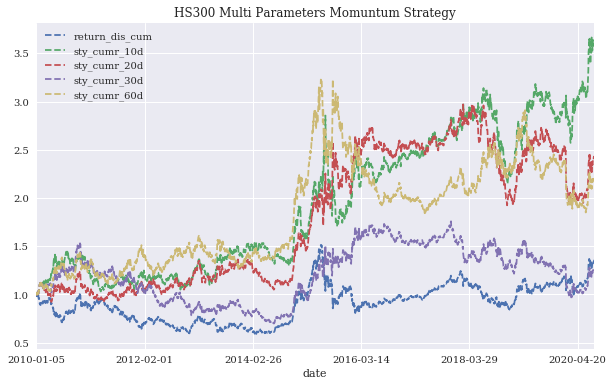

In [22]:
data[price_plot].dropna().plot(
    title='HS300 Multi Parameters Momuntum Strategy',
    figsize=(10, 6), style=['--', '--', '--', '--','--'])

#### 5.  策略优化思路之 

High Frequency Data用于Momentum策略

In [23]:
hs300_hf = ts.get_k_data('hs300', ktype='5')

In [24]:
hs300_hf.head()

,date,open,close,high,low,volume,amount,turnoverratio,code
0,2020-07-30 09:35,4689.76,4682.08,4691.35,4676.27,17243583.0,{},0.0000,hs300
1,2020-07-30 09:40,4682.43,4704.11,4704.63,4682.43,9217654.0,{},0.0000,hs300
2,2020-07-30 09:45,4702.52,4688.79,4702.52,4688.79,7777231.0,{},0.0000,hs300
3,2020-07-30 09:50,4688.61,4686.02,4690.89,4681.14,7464776.0,{},0.0000,hs300
4,2020-07-30 09:55,4686.13,4666.06,4688.48,4666.06,7031282.0,{},0.0000,hs300


In [25]:
hs300_hf.set_index('date',inplace = True)

In [26]:
hs300_hf.head()

,open,close,high,low,volume,amount,turnoverratio,code
date,,,,,,,,
2020-07-30 09:35,4689.76,4682.08,4691.35,4676.27,17243583.0,{},0.0000,hs300
2020-07-30 09:40,4682.43,4704.11,4704.63,4682.43,9217654.0,{},0.0000,hs300
2020-07-30 09:45,4702.52,4688.79,4702.52,4688.79,7777231.0,{},0.0000,hs300
2020-07-30 09:50,4688.61,4686.02,4690.89,4681.14,7464776.0,{},0.0000,hs300
2020-07-30 09:55,4686.13,4666.06,4688.48,4666.06,7031282.0,{},0.0000,hs300


In [27]:
hs300_hf.index = pd.to_datetime(hs300_hf.index)  

In [28]:
hs300_hf.tail()

,open,close,high,low,volume,amount,turnoverratio,code
date,,,,,,,,
2020-08-12 14:40:00,4641.15,4637.96,4641.15,4632.72,2905881.0,{},0.0000,hs300
2020-08-12 14:45:00,4638.04,4640.62,4640.93,4638.04,3544854.0,{},0.0000,hs300
2020-08-12 14:50:00,4641.62,4646.09,4646.89,4641.58,3977376.0,{},0.0000,hs300
2020-08-12 14:55:00,4645.88,4645.31,4645.88,4643.87,4342857.0,{},0.0000,hs300
2020-08-12 15:00:00,4645.51,4647.64,4647.64,4645.20,3186809.0,{},0.0000,hs300


In [29]:
type(hs300_hf.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [30]:
hs300_hf.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 2020-07-30 09:35:00 to 2020-08-12 15:00:00
Data columns (total 8 columns):
open             480 non-null float64
close            480 non-null float64
high             480 non-null float64
low              480 non-null float64
volume           480 non-null float64
amount           480 non-null object
turnoverratio    480 non-null object
code             480 non-null object
dtypes: float64(5), object(3)
memory usage: 33.8+ KB


In [31]:
hs300_hf['returns'] = np.log(hs300_hf['close'] / hs300_hf['close'].shift(1))

In [32]:
hs300_hf['position'] = np.sign(hs300_hf['returns'].rolling(30).mean())     #30个5分钟平均；

In [33]:
hs300_hf['strategy'] = hs300_hf['position'].shift(1) * hs300_hf['returns']

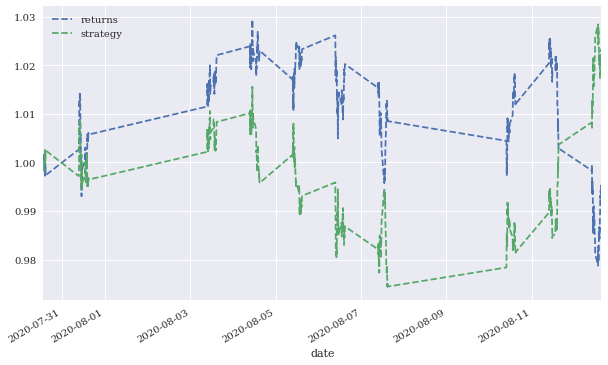

In [34]:
hs300_hf[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6), style=['--', '--'])

#### 6. Cross sectional 横截面行业内动量

策略逻辑与执行思路：

初选股票池： HS300/ZZ500/全A

将股票池内股票按行业分类

重新定股票池：每个行业中，过去n天内涨的最好的n只股票

股票在股票池中买入，不在股票池中卖出，以n天为周期进行调整

参数n寻优，回测结果评价。

适合在优矿米宽万矿等平台上执行。

In [35]:
ts.get_index()

,code,name,change,open,preclose,close,high,low,volume,amount
0,000001,上证指数,-0.63,3327.4929,3340.2900,3319.2656,3335.7290,3263.2653,378328959,4807.3125
1,000002,Ａ股指数,-0.63,3487.8473,3501.2795,3479.2114,3496.4860,3420.4909,378017313,4805.5526
2,000003,Ｂ股指数,-0.15,235.7005,235.9153,235.5730,236.1914,232.3598,311646,1.7598
3,000008,综合指数,-0.27,2957.3565,2964.0294,2955.9167,2975.8872,2919.8133,82517256,1007.2365
4,000009,上证380,-1.40,5975.4179,5998.0089,5913.8670,5988.7996,5802.1414,92917254,1106.1501
5,000010,上证180,-0.60,9639.1210,9671.6450,9614.0586,9667.2101,9459.4974,126295482,1936.2061
6,000011,基金指数,-0.56,7194.2378,7212.5258,7172.3285,7205.4516,7074.7891,143927550,464.7485
7,000012,国债指数,0.04,182.7022,182.6868,182.7544,182.7641,182.7022,223595,2.1124
8,000016,上证50,-0.40,3255.5383,3262.8244,3249.7381,3266.5825,3199.5458,51024947,1000.1235
9,000017,新综指,-0.63,2812.3547,2823.1887,2805.3976,2819.3231,2758.0485,362797038,4383.5167
